# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 2. Data Loading

In [2]:
data = pd.read_excel('E:\GitHub\sherlock-final-project\pooled_data.xlsx', sheet_name="data")
data = data.iloc[:, 1:4]
data_ar = np.array(data)

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

multico = sm.add_constant(data)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = multico.columns
vif["VIF"] = [variance_inflation_factor(multico.values, i) for i in range(multico.shape[1])]

print(vif)

  Variable        VIF
0    const  88.710184
1       x1   1.023016
2       x2   1.022990
3       x3   1.000078


## 3. Terasvirta Linearity Test
#### Done in R language, check at terasvirta_acfpacf.R

## 4. ACF-PACF Test
#### Done in R language, check at terasvirta_acfpacf.R

## 5. Min-Max Normalization

In [8]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = normalize_data(data_ar[:,0].reshape(-1,1))
x2_norm, x2_scaler = normalize_data(data_ar[:,1].reshape(-1,1))
x3_norm, x3_scaler = normalize_data(data_ar[:,2].reshape(-1,1))

x1_data = np.column_stack([x1_norm[34:612],x1_norm[:578]])
x2_data = np.column_stack([x2_norm[34:612],x2_norm[:578]])
x3_data = np.column_stack([x3_norm[34:612],x3_norm[:578]])

## 6. Data Splitting and Windowing

In [9]:
# Split function at the 442nd index
def split_data_at_index(data, index=442):
    train_data = data[:index]
    test_data = data[index:]
    return train_data, test_data

# Splitting the datasets
x1_train, x1_test = split_data_at_index(x1_data)
x2_train, x2_test = split_data_at_index(x2_data)
x3_train, x3_test = split_data_at_index(x3_data)

# Prefetch function
def prefetch_dataset(features, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    return ds.batch(batch_size).prefetch(1)

# Prepare the datasets for x1, x2, and x3 data
batch_size = 32  # Adjust as necessary

# For x1 data
x1_train_features = x1_train[:, 1]
x1_train_labels = x1_train[:, 0]
x1_test_features = x1_test[:, 1]
x1_test_labels = x1_test[:, 0]

x1_train_set = prefetch_dataset(x1_train_features, x1_train_labels, batch_size)
x1_test_set = prefetch_dataset(x1_test_features, x1_test_labels, batch_size)

# For x2 data
x2_train_features = x2_train[:, 1]
x2_train_labels = x2_train[:, 0]
x2_test_features = x2_test[:, 1]
x2_test_labels = x2_test[:, 0]

x2_train_set = prefetch_dataset(x2_train_features, x2_train_labels, batch_size)
x2_test_set = prefetch_dataset(x2_test_features, x2_test_labels, batch_size)

# For x3 data
x3_train_features = x3_train[:, 1]
x3_train_labels = x3_train[:, 0]
x3_test_features = x3_test[:, 1]
x3_test_labels = x3_test[:, 0]

x3_train_set = prefetch_dataset(x3_train_features, x3_train_labels, batch_size)
x3_test_set = prefetch_dataset(x3_test_features, x3_test_labels, batch_size)

## 7. Neural Network Architecture and Modelling

In [12]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node, replication, data_index):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(1,)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset, callbacks=[early_stopping])
        if __name__ == '__main__':
                model.save(f"model_x{data_index}_{replication}_{hidden_node}.h5")
        train_loss = history.history['loss'][-1]
        test_loss = history.history['val_loss'][-1]
        train_epoch = len(history.epoch)
        weights = model.get_weights()
        return train_loss, test_loss, train_epoch, weights[0], weights[1], weights[2], weights[3]

In [14]:
modelling(train_dataset=x1_train_set, 
                                    test_dataset=x1_test_set,
                                    epoch=500, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=18,
                                    replication=4,
                                    data_index=1)


Epoch 1/500

14/14 [==============================] - 1s 11ms/step - loss: 0.0255 - val_loss: 0.0148
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0133
Epoch 3/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0126
Epoch 4/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0124
Epoch 5/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0122
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0121
Epoch 7/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0121
Epoch 8/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0120
Epoch 9/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0120
Epoch 10/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0120
Epoch 

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(0.02210192196071148,
 0.012063905596733093,
 17,
 array([[-0.02600984, -0.28972742,  0.4707039 , -0.00741705,  0.16568454,
          0.24704234,  0.48099488,  0.57292086,  0.18005818, -0.17298391,
         -0.19448581, -0.47106412,  0.4167505 , -0.504778  ,  0.24175386,
         -0.3733025 , -0.22709148, -0.37286195]], dtype=float32),
 array([-0.02808148, -0.0277691 ,  0.02634143, -0.00958611, -0.04660485,
        -0.01818522,  0.02675867,  0.0269208 ,  0.02050401,  0.02011628,
         0.01810494,  0.01919349, -0.02244843, -0.03074062,  0.02103062,
         0.01826609,  0.01954675, -0.02761563], dtype=float32),
 array([[ 0.1229094 ],
        [ 0.37285063],
        [ 0.41457334],
        [ 0.02088456],
        [-0.29028827],
        [-0.02422492],
        [ 0.11891487],
        [ 0.4560014 ],
        [ 0.37189633],
        [-0.3625264 ],
        [-0.16731626],
        [-0.51380247],
        [-0.33646324],
        [ 0.46411687],
        [ 0.12340844],
        [-0.31819984],
        [-0

In [ ]:
train_sets = [train_set1, train_set2, train_set3]
test_sets = [test_set1, test_set2, test_set3]
data_index = 0

for train_set, test_set in zip(train_sets, test_sets):
    data_index += 1
    model_sum = pd.DataFrame(columns=['replication', 'hidden_node', 'train_mse', 'test_mse', 'epoch', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
    for rep in range(1, 6):
        iterasi = (rep - 1) * 20 + 1
        for n in range(1, 21):
            a,b,c,d,e,f,g = modelling(train_dataset=train_set, 
                                    test_dataset=test_set,
                                    epoch=50, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=n,
                                    replication=rep,
                                    data_index=data_index)
            idx = iterasi + n
            model_sum.loc[idx] = [rep,n,a,b,c,d,e,f,g]
    model_sum.to_excel(f'model_x{data_index}_summary.xlsx')                

## 9. Prediction

In [15]:
modelx1 = tf.keras.models.load_model('model_x1_4_18.h5')
modelx2 = tf.keras.models.load_model('x2/model_x2_1_2.h5')
modelx3 = tf.keras.models.load_model('x3/model_x3_4_1.h5')

### X1 (Tingkat Pertumbuhan Ekonomi)

In [18]:
initial_input_data = np.zeros(136)
initial_input_data[:34] = x1_norm[578:612].ravel()

1/1 [==============================] - 0s 23ms/step
[0.0820207  0.10720387 0.09142864 0.08347879 0.09497052 0.10787421
 0.09330978 0.1001652  0.08318716 0.1001652  0.10530454 0.10463419
 0.10385212 0.10563971 0.10273486 0.10563971 0.11971771 0.02679574
 0.05048853 0.0983776  0.10997341 0.09949485 0.11814287 0.10083555
 0.1117451  0.22862323 0.08070844 0.10938285 0.10228796 0.12099726
 0.09983002 0.40790406 0.10295832 0.08923303 0.08923303 0.10335757
 0.09499158 0.09022694 0.09691188 0.10371077 0.09603684 0.09964893
 0.09002815 0.09964893 0.10235681 0.10200361 0.10159154 0.10253341
 0.10100286 0.10253341 0.10973606 0.04150763 0.06712732 0.09870706
 0.10481682 0.09929572 0.10900505 0.10000213 0.10575031 0.16028818
 0.08833854 0.10450566 0.1007674  0.11033002 0.09947234 0.23741747
 0.10112061 0.09376328 0.09376328 0.10133097 0.09692297 0.09431931
 0.09793477 0.10151706 0.09747371 0.09937691 0.0942081  0.09937691
 0.10080367 0.10061757 0.10040046 0.10089672 0.1000903  0.10089672
 0.1046917

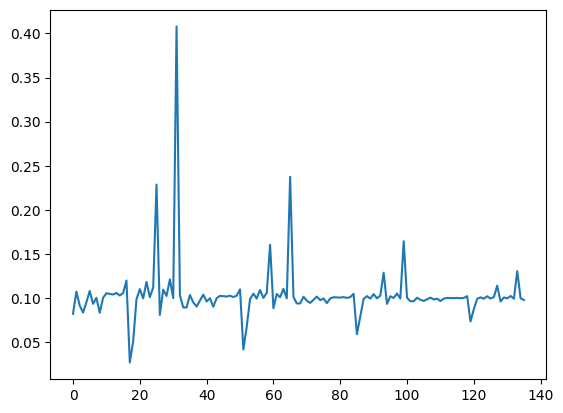

In [22]:


# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for i in range(num_predictions):
    # Predict the next data point
    next_pred = modelx1.predict(current_input[i].reshape(-1,1))
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    if i + 34 < 136:
        initial_input_data[i + 34] = next_pred.squeeze()
    
    current_input = initial_input_data

# Convert the list of predictions to a NumPy array
x1predictions = np.array(predictions)

print(x1predictions)
plt.plot(x1predictions)

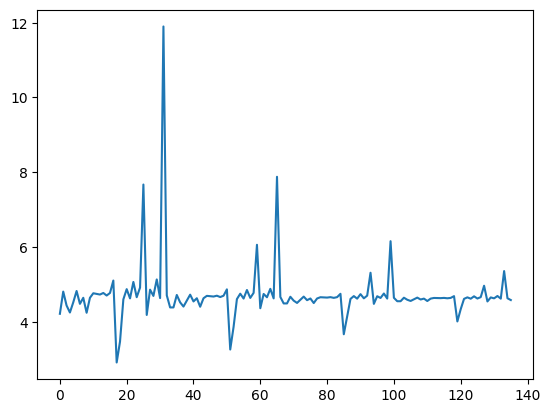

In [23]:
x1predictions = x1predictions.reshape(-1,1)
x1_pred = x1_scaler.inverse_transform(x1predictions).flatten()
plt.plot(x1_pred)

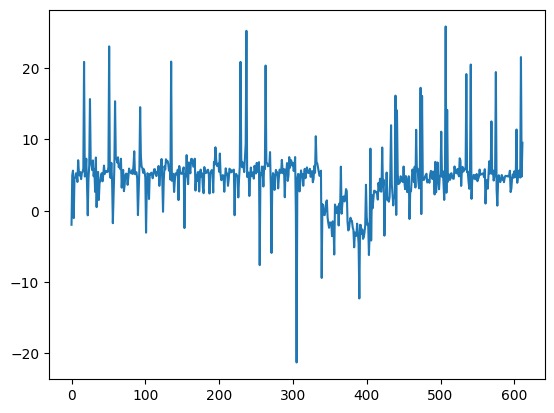

In [15]:
plt.plot(data['x1'])

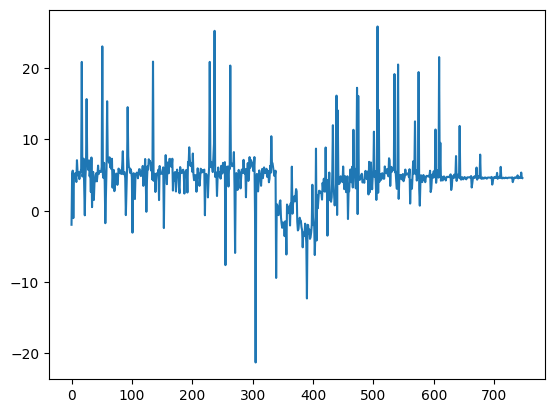

In [24]:
reshaped_previous_data = data_ar[:,0].T

# Combine reshaped data and reshaped previous data
combined_data = np.concatenate((reshaped_previous_data, x1_pred.flatten()))

plt.plot(combined_data.reshape(-1,1))

### X2 (Tingkat Pengangguran Terbuka)

In [16]:
initial_input_data = x2_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx2.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x2predictions = np.array(predictions)

print(x2predictions)


1/1 [==============================] - 0s 24ms/step
[-0.03883916 -0.06107852 -0.05630365 -0.357868   -0.28077933 -0.32283095
 -0.4738811  -0.2446126  -0.24226573  0.21182112  0.11429849  0.37555432
 -0.10240075 -0.32929018 -0.10073248  0.42348203 -0.42764542 -0.43007055
 -0.34520194  0.02839836 -0.11690876 -0.21406588  0.03521487 -0.13880977
  0.19590557 -0.43363634 -0.17847398 -0.45781937 -0.4180825  -0.472401
  0.17192945 -0.1899359  -0.04964665 -0.39189658 -0.00708497 -0.0254623
 -0.11769804 -0.3266724  -0.24553058 -0.20335326 -0.46031865 -0.13784447
 -0.25072762  0.21339864  0.13781276  0.35781333 -0.12543568 -0.2777185
 -0.12084463  0.414499   -0.23063818 -0.3395578  -0.196718    0.08660161
  0.03316665 -0.1158953   0.13666087 -0.00312638  0.3204822  -0.27813503
 -0.01525807 -0.29076353 -0.24838641 -0.20337573  0.26224494 -0.0447087
  0.03489134 -0.19923285  0.08882022  0.09534287 -0.14456615 -0.20692262
 -0.13339427 -0.00925112 -0.37323603  0.02028549 -0.19368222  0.228897
  0.18

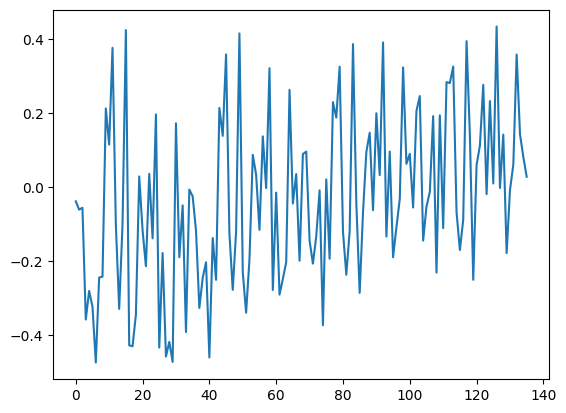

In [17]:
plt.plot(x2predictions)

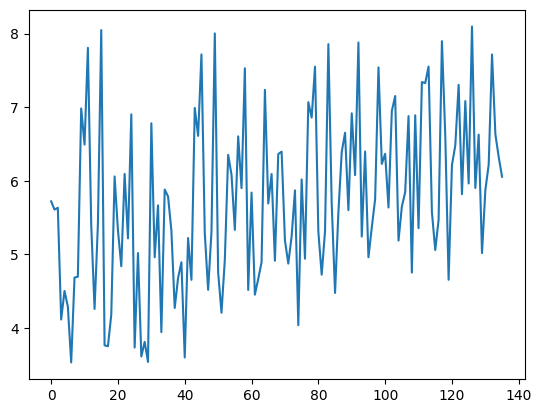

In [18]:
x2predictions = x2predictions.reshape(-1,1)
x2_pred = x2_scaler.inverse_transform(x2predictions).flatten()
plt.plot(x2_pred)

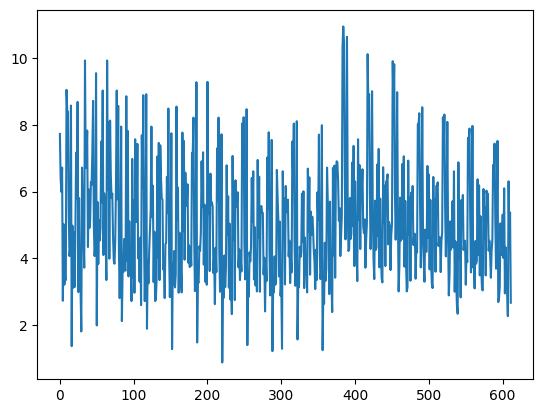

In [19]:
plt.plot(data['x2'])

### X3 (Rasio Gini)

In [20]:
initial_input_data = x3_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx3.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x3predictions = np.array(predictions)

print(x3predictions)

1/1 [==============================] - 0s 23ms/step
[-0.4044646  -0.29957414 -0.7213602  -0.1678037  -0.01479644 -0.06036001
 -0.11442953 -0.44939137 -0.9940318  -0.09898341  0.6865536   0.55700463
  0.24955305  0.6865536   0.27445295  0.235253    0.16947693  0.23329979
 -0.15421492 -0.3222332  -0.19512331 -0.2856654  -0.18362278 -0.6524763
  0.14589107 -0.450801    0.19610748  0.2438665   0.6177242   0.09190583
 -0.5405408  -0.33545804  0.20933321  0.42936453 -0.36747718 -0.32949996
 -0.7403183  -0.14725846 -0.05942589 -0.02971351 -0.1033653  -0.48640192
 -0.9948667  -0.08903265  0.6865536   0.56081724  0.30284134  0.681232
  0.23277327  0.26371604  0.20790944  0.2319789  -0.12271583 -0.39330757
 -0.22938448 -0.24856687 -0.17747527 -0.67125165  0.10921293 -0.41551864
  0.16990554  0.27482593  0.6448845   0.07099324 -0.5095738  -0.3394363
  0.2061564   0.44101745 -0.3407668  -0.36475098 -0.74246156 -0.15002865
 -0.09401065  0.00454062 -0.1002602  -0.5199349  -1.001099   -0.07343245
  0

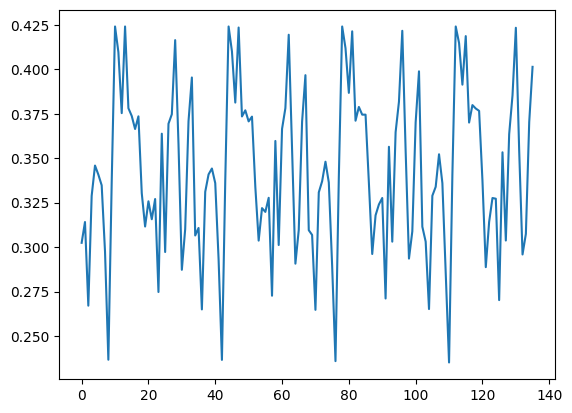

In [21]:
x3predictions = x3predictions.reshape(-1,1)
x3_pred = x3_scaler.inverse_transform(x3predictions).flatten()
plt.plot(x3_pred)

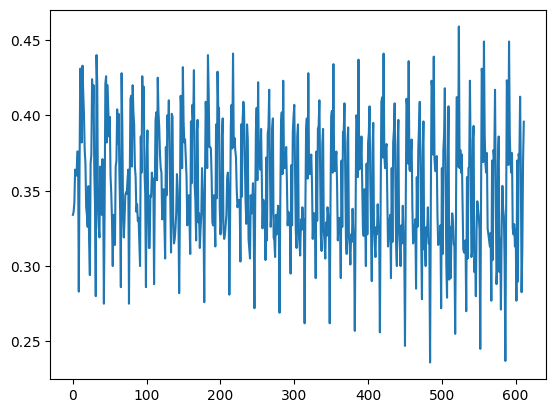

In [22]:
plt.plot(data['x3'])

## 10. Prediction Recap

In [23]:
model_pred = np.column_stack((x1_pred, x2_pred, x3_pred))
model_pred = pd.DataFrame(model_pred, columns=['x1', 'x2', 'x3'])
model_pred.to_excel('x_prediction_3.xlsx')